In [13]:
import pandas as pd

# Import the CSV file
df_endpoints = pd.read_csv('porto_end_points.csv')

In [16]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3400, random_state=42, n_init=10)
kmeans.fit_predict(df_endpoints[['latitude', 'longitude']])

array([ 160,  395, 1639, ..., 3329,  713,  817])

In [17]:
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude'])
centroids_df.to_csv(f'end_point_centroids_k3400.csv', index=False)

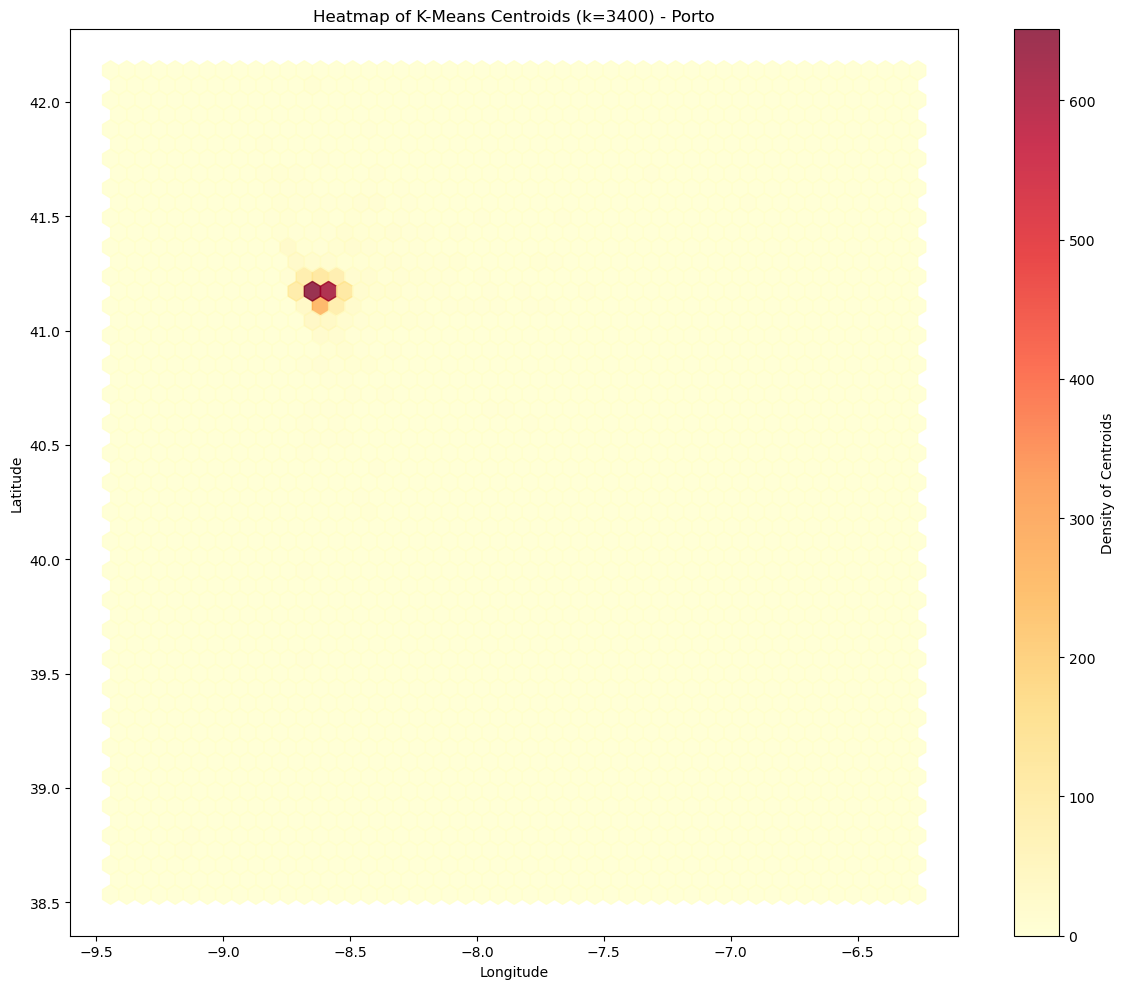

In [ ]:
import folium

# Create a folium map centered on Porto
porto_map = folium.Map(
    location=[41.1579, -8.6291],  # Porto center coordinates
    zoom_start=12,
    tiles='OpenStreetMap'
)

# Add centroids to the map
for idx, row in centroids_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        popup=f'Centroid {idx}',
        color='red',
        fill=True,
        fillOpacity=0.6
    ).add_to(porto_map)

# Display the map
porto_map

In [22]:
import pickle

with open('porto_filtered_clean_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [23]:
print(len(data))

442


In [26]:
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn_model.fit(centroids_df[['latitude', 'longitude']].values)

,n_neighbors,1
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'euclidean'
,p,2
,metric_params,None
,n_jobs,None


In [ ]:
test_taxi_ids = list(data.keys())[-12:]
test_data = []

for taxi_id in test_taxi_ids:
    for _, trip_df in data[taxi_id].items():

        last_point = trip_df.iloc[-1]
        point = [last_point['latitude'], last_point['longitude']]
        _, indices = nn_model.kneighbors([point])
        end_centroid_idx = indices[0][0]

        seq = trip_df[['latitude', 'longitude']].iloc[:-1].values.tolist()
        # format is sequence , y real, y_centroid
        extracted_data = [seq, point, end_centroid_idx]
        test_data.append(extracted_data)

with open('new_porto_data/new_porto_test_data.pkl', 'wb') as file:
    pickle.dump(test_data, file)


In [40]:
remaining_taxi_ids = list(data.keys())[:-12]
num_parts = 5
part_size = len(remaining_taxi_ids) // num_parts

for part_idx in range(num_parts):
    start_idx = part_idx * part_size
    if part_idx == num_parts - 1:
        end_idx = len(remaining_taxi_ids)
    else:
        end_idx = (part_idx + 1) * part_size
    
    part_taxi_ids = remaining_taxi_ids[start_idx:end_idx]
    part_data = []
    
    for taxi_id in part_taxi_ids:
        for _, trip_df in data[taxi_id].items():
            last_point = trip_df.iloc[-1]
            point = [last_point['latitude'], last_point['longitude']]
            _, indices = nn_model.kneighbors([point])
            end_centroid_idx = indices[0][0]
            
            seq = trip_df[['latitude', 'longitude']].iloc[:-1].values.tolist()
            extracted_data = [seq, point, end_centroid_idx]
            part_data.append(extracted_data)
    
    with open(f'new_porto_data/new_porto_train_data_part_{part_idx}_{num_parts}.pkl', 'wb') as file:
        pickle.dump(part_data, file)
    
    print(f"Part {part_idx}: {len(part_taxi_ids)} taxi IDs, {len(part_data)} trips")

Part 0: 86 taxi IDs, 437753 trips
Part 1: 86 taxi IDs, 341172 trips
Part 2: 86 taxi IDs, 299978 trips
Part 3: 86 taxi IDs, 303403 trips
Part 4: 86 taxi IDs, 269666 trips


In [4]:
import pickle
import pandas as pd
with open('new_porto_data/new_porto_test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)

centroids_df = pd.read_csv('new_porto_data/end_point_centroids_k3400.csv')

In [105]:
import folium
import random

print(len(centroids_df))

random_index = random.randint(0, len(test_data) - 1)

first_y = test_data[random_index][1]
first_centroid_index = test_data[random_index][2]
print(first_y)
print(first_centroid_index)

print(centroids_df.iloc[first_centroid_index])

# Create a map centered on the first point
map_center = folium.Map(
    location=first_y,
    zoom_start=15,
    tiles='OpenStreetMap'
)

folium.Marker(
    location=first_y,
    popup='Actual Endpoint',
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(map_center)

centroid_coords = [centroids_df.iloc[first_centroid_index]['latitude'], 
                   centroids_df.iloc[first_centroid_index]['longitude']]
folium.Marker(
    location=centroid_coords,
    popup=f'Centroid {first_centroid_index}',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(map_center)

map_center

3400
[41.155164, -8.638407]
3389
latitude     41.154707
longitude    -8.638212
Name: 3389, dtype: float64


In [1]:
import pickle
with open('porto_filtered_clean_data.pkl', 'rb') as file:
    porto_data = pickle.load(file)

In [2]:
all_latitudes = []
all_longitudes = []
for taxi_id, trips in porto_data.items():
    for trip_id, trip_df in trips.items():
        all_latitudes.extend(trip_df['latitude'].tolist())
        all_longitudes.extend(trip_df['longitude'].tolist())

In [3]:
print(len(all_latitudes), len(all_longitudes))

83286453 83286453


In [4]:
import numpy as np

lat_mean = np.mean(all_latitudes)
lat_std = np.std(all_latitudes)
lon_mean = np.mean(all_longitudes)
lon_std = np.std(all_longitudes)

print(f"Latitude - Mean: {lat_mean}, Std: {lat_std}")
print(f"Longitude - Mean: {lon_mean}, Std: {lon_std}")

Latitude - Mean: 41.15940314187152, Std: 0.07367446333478521
Longitude - Mean: -8.616175170744098, Std: 0.05705206609122599
